# Learning rate finder

In [64]:
import torchvision
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [4]:
class MLP(nn.Module):
    
    def __init__(self, num_in, num_hidden, num_out):
        # 親のclassの継承
        super().__init__()
        # flattenはよく使う (画像データの場合1番最初のLinear層の前には必ず使うと思って良い.)
        self.flatten = nn.Flatten() # [b, c, h, w] -> [b, cxhxw] 
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out) # 出力層の全結合層

    # forwardの処理(順伝播の処理)
    def forward(self, x):
        x = self.l2(F.relu(self.l1(self.flatten(x))))
        return x


class MyDataset(Dataset):

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y


def learn(model, train_loader, val_loader, opt, loss_func, num_epoch, early_stopping=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    # early_stopping用
    best_val_loss = float('inf')
    no_improve = 0  # カウント用
    
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
    
    
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            
            # 順伝播と逆伝播の計算
            opt.zero_grad()
            # forward
            preds  = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backword
            loss.backward()
            opt.step()
    
        # validtion
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_accuracy/(val_batch + 1))
        print(f'epoch : {epoch}: train error : {train_losses[-1]}, validation error : {val_losses[-1]},val accuracy {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
        else:
            # 改善が見られなかったら
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break

    return train_losses, val_losses, val_accuracies

In [56]:
        
#データ準備
dataset = datasets.load_digits()
target = dataset['target']
images = dataset['images']
# imagesのnumpy配列が0 ~ 16 -> 0 ~ 255に変換
images = images * (255. / 16.)
images = images.astype(np.uint8)

# 学習データと検証データ
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# tensor変換
transform = transforms.Compose([
    transforms.ToTensor(), # 0 ~ 255 -> 0 ~ 1
    transforms.Normalize((0.5, ), (0.5, )), # 0 ~ 1 -> -1 ~ 1
])

# DatasetとDataLoader
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)


num_in = 64
num_hidden = 30
num_out = 10

learning_rate = 0.05

# モデルの初期化
model = MLP(num_in, num_hidden, num_out)
opt = optim.SGD(model.parameters(), lr = learning_rate)

num_epoch = 100

train_losses, val_losses, val_accuracy = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5)

epoch : 0: train error : 2.1458670404222278, validation error : 1.943111519018809,val accuracy 0.4453125
epoch : 1: train error : 1.640788573688931, validation error : 1.3855835398038228,val accuracy 0.7369791666666666
epoch : 2: train error : 1.1118575678931342, validation error : 0.8902818709611893,val accuracy 0.8385416666666666
epoch : 3: train error : 0.7392504493395488, validation error : 0.6110600059231123,val accuracy 0.9140625
epoch : 4: train error : 0.5286312500635783, validation error : 0.454592098792394,val accuracy 0.9088541666666666
epoch : 5: train error : 0.4056688967678282, validation error : 0.3697205036878586,val accuracy 0.9270833333333334
epoch : 6: train error : 0.3310047295358446, validation error : 0.30996207023660344,val accuracy 0.9348958333333334
epoch : 7: train error : 0.2850823816325929, validation error : 0.26520848895112675,val accuracy 0.9401041666666666
epoch : 8: train error : 0.24752234121163685, validation error : 0.23855889216065407,val accuracy 0

In [57]:
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    # early_stopping用
    best_val_loss = float('inf')
    no_improve = 0  # カウント用
    
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
    
    
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            
            # 順伝播と逆伝播の計算
            opt.zero_grad()
            # forward
            preds  = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backword
            loss.backward()
            opt.step()
    
        # validtion
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_accuracy/(val_batch + 1))
        print(f'epoch : {epoch}: train error : {train_losses[-1]}, validation error : {val_losses[-1]},val accuracy {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'val_loss' : val_losses[-1],
                }
                torch.save(state, save_path)
        else:
            # 改善が見られなかったら
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break

    return train_losses, val_losses, val_accuracies

In [58]:
opt.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3]}]}

In [59]:
# learning_rate_finderを実装
def lr_finder(model, train_loader, loss_func, lr_multiplier=1.2):

    lr = 1e-8
    max_lr = 10
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    lrs = []

    for train_batch, data in enumerate(train_loader):
        X, y = data

        opt.zero_grad()
        # forward
        preds = model(X)
        loss = loss_func(preds, y)
        losses.append(loss.item())
        lrs.append(lr)

        # backward
        loss.backward()
        opt.step()

        lr *= lr_multiplier

        # 新しい学習率を適用
        for param_group in opt.param_groups:
            param_group['lr'] = lr
        if lr > max_lr:
            break
            

    return lrs, losses

In [60]:
lrs, losses = lr_finder(model, train_loader, F.cross_entropy, lr_multiplier=1.2)

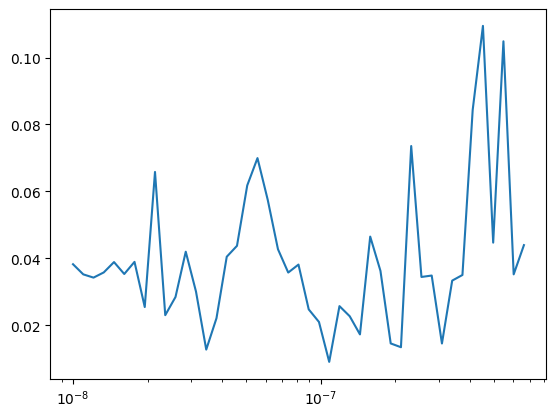

In [61]:
plt.plot(lrs, losses)
plt.xscale('log')

## Learning rate scheduler

In [70]:
# モデルの初期化
model = MLP(64, 30, 10)
learning_rate = 0.1
opt = optim.SGD(model.parameters(), lr = learning_rate)

# StepLR
scheduler = StepLR(opt, step_size=30, gamma=0.1)
for param_group in opt.param_groups:
    print(param_group['lr'])

for epoch in range(30):
    scheduler.step()

for param_group in opt.param_groups:
    print(param_group['lr'])



0.1
0.010000000000000002


/usr/local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [74]:
# CosineAnnialing

# モデルの初期化
model = MLP(64, 30, 10)
learning_rate = 0.1
opt = optim.SGD(model.parameters(), lr = learning_rate)

scheduler = CosineAnnealingLR(opt, T_max =50)
lrs = []

for epoch in range(150):
    lrs.append(opt.param_groups[0]['lr'])
    scheduler.step()


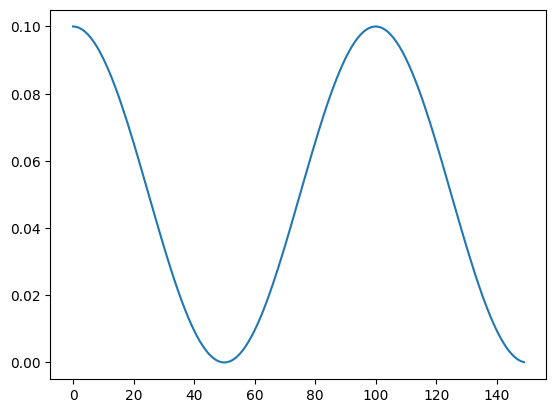

In [76]:
plt.plot(lrs)

In [77]:
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None, scheduler=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    # early_stopping用
    best_val_loss = float('inf')
    no_improve = 0  # カウント用
    
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
    
    
        for train_batch, data in enumerate(train_loader):
    
            X, y = data
            
            # 順伝播と逆伝播の計算
            opt.zero_grad()
            # forward
            preds  = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backword
            loss.backward()
            opt.step()
    
        # validtion
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_accuracy += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_accuracy/(val_batch + 1))
        print(f'epoch : {epoch}: train error : {train_losses[-1]}, validation error : {val_losses[-1]},val accuracy {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'val_loss' : val_losses[-1],
                }
                torch.save(state, save_path)
        else:
            # 改善が見られなかったら
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, val_accuracies

In [78]:
model = MLP(64, 30, 10)
learning_rate = 0.1
opt = optim.SGD(model.parameters(), lr = learning_rate)

# StepLR
scheduler = StepLR(opt, step_size=30, gamma=0.1)

traiin_losses, val_losses, val_accuracy = learn(model, train_loader, val_loader, opt, F.cross_entropy, 100, scheduler=scheduler)

epoch : 0: train error : 1.875695326593187, validation error : 1.2575966119766235,val accuracy 0.8359375
epoch : 1: train error : 0.8433253228664398, validation error : 0.5607836842536926,val accuracy 0.890625
epoch : 2: train error : 0.42270980411105685, validation error : 0.36782676354050636,val accuracy 0.921875
epoch : 3: train error : 0.2936821834908591, validation error : 0.2738252269725005,val accuracy 0.9244791666666666
epoch : 4: train error : 0.23067666904793846, validation error : 0.2258130485812823,val accuracy 0.9401041666666666
epoch : 5: train error : 0.197367243303193, validation error : 0.20331285956005254,val accuracy 0.9348958333333334
epoch : 6: train error : 0.17306270135773552, validation error : 0.17902673160036406,val accuracy 0.9453125
epoch : 7: train error : 0.15244633961055015, validation error : 0.1864791993672649,val accuracy 0.9453125
epoch : 8: train error : 0.13854031388958296, validation error : 0.1578098200261593,val accuracy 0.9505208333333334
epoch 

In [79]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[ 0.0774, -0.0122, -0.2956,  ...,  0.1141, -0.0777,  0.0364],
           [ 0.0491, -0.0510, -0.0700,  ..., -0.0370, -0.0143,  0.0176],
           [ 0.0846, -0.0587,  0.1239,  ..., -0.0556,  0.0308, -0.0585],
           ...,
           [-0.1488, -0.0265,  0.0806,  ...,  0.4623,  0.5166,  0.1792],
           [-0.1362, -0.0287, -0.1948,  ...,  0.0024, -0.0006, -0.0995],
           [ 0.0437, -0.0139,  0.1742,  ..., -0.3805, -0.3171,  0.0322]],
          requires_grad=True),
   Parameter containing:
   tensor([ 0.0136, -0.0573, -0.0886, -0.0523, -0.1010, -0.1307, -0.0161,  0.0249,
            0.0923,  0.1094,  0.1740,  0.0303, -0.1134,  0.0728, -0.0022, -0.0231,
            0.0838,  0.0026,  0.0689,  0.0033,  0.0361, -0.0529, -0.0652,  0.2047,
           -0.0475,  0.0682,  0.0070,  0.0631,  0.2184, -0.0065],
          requires_grad=True),
   Parameter containing:
   tensor([[-3.9475e-01, -5.7359e-03,  7.7542e-02,  1.7795e-01,  1.0771e-01,
      